In [2]:
from neo4j import GraphDatabase
from langchain.vectorstores import FAISS 
from langchain.chains import RetrievalQA
from langchain.llms import Ollama
from langchain_ollama import OllamaEmbeddings
from langchain.llms import Ollama
from tqdm import tqdm
from langchain_ollama import ChatOllama
from langchain_community.graphs.neo4j_graph import Neo4jGraph
import random
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from sklearn.metrics import precision_score


import collections as c
import pandas as pd
import numpy as np
import ast
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


In [3]:

result_file = f'results/all_results-v3.csv'
df = pd.read_csv(result_file, sep=',')
len(df)
#df


1000

In [4]:
import pandas as pd
import ast
from sklearn.metrics import precision_score

def clean_model_list(val):
    
    if isinstance(val, list):
        cleaned_list = []
        for item in val:
            cleaned_list.extend(clean_model_list(item))  
        return cleaned_list
    
    if isinstance(val, str):
        if val.startswith('["') and val.endswith('"]'):
            return [val[2:-2]]  
        
        try:
            evaluated = ast.literal_eval(val)
            if isinstance(evaluated, list):
                return clean_model_list(evaluated)  
        except (SyntaxError, ValueError):
            pass  
    
        if ',' in val:
            return [item.strip() for item in val.split(',')]
    
    return [str(val)]


def create_model_overlap(df, models):
    
    for model in models:
        overlap_col = f"{model}_overlap"
        model_overlap_list = []

        for _, row in df.iterrows():
            gold_label = row['gold_label']
            model_pred = row[model]  

            gold_set = set(gold_label)
            model_set = set(model_pred)
            overlap = gold_set.intersection(model_set)

            if overlap:

                model_overlap_list.append(gold_label)
            else:
                # If there is no overlap, assign a placeholder to make it different
                model_overlap_list.append(["item_X"])  

        df[overlap_col] = model_overlap_list

    return df




# Define models
models = ['llama', 'mistral', 'gemma', 'phi']

df['gold_label'] = df['gold_label'].apply(lambda x: clean_model_list(ast.literal_eval(x)))

for model in models:
    df[model] = df[model].apply(lambda x: clean_model_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])

for model in models:
    df[model] = df[model].apply(lambda x: [str(item) for item in x])

df = create_model_overlap(df, models)

precision_scores = {}

for model in models:
    y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
    y_pred = df[f"{model}_overlap"].apply(lambda x: x[0]).tolist()
    precision_scores[model] = precision_score(y_true, y_pred, average='micro')


print("\nPrecision Scores:")
for model, score in precision_scores.items():
    print(f"{model}: {score}")

df



Precision Scores:
llama: 0.557
mistral: 0.727
gemma: 0.562
phi: 0.828


,groupId,group_size,num_items,strategy,gold_label,llama,mistral,gemma,phi,llama_overlap,mistral_overlap,gemma_overlap,phi_overlap
0,1,4,5,LMS,"[item_1, item_5]",[item_3],"[item_3, item_5]",[item_1],"[item_1, item_5]",[item_X],"[item_1, item_5]","[item_1, item_5]","[item_1, item_5]"
1,2,8,5,ADD,[item_1],"[item_2, item_3]","[item_2, item_5]","[item_2, item_4]",[item_1],[item_X],[item_X],[item_X],[item_1]
2,3,4,5,APP,[item_3],[item_3],[item_5],[item_5],[item_3],[item_3],[item_X],[item_X],[item_3]
3,4,8,5,ADD,[item_1],[item_2],[item_5],[item_2],[item_1],[item_X],[item_X],[item_X],[item_1]
4,5,2,5,ADD,[item_5],[item_2],"[item_4, item_5]","[item_2, item_5]",[item_5],[item_X],[item_5],[item_5],[item_5]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1333,2,10,ADD,[item_10],[item_2],"[item_2, item_10]",[item_2],[item_10],[item_X],[item_10],[item_X],[item_10]
996,1334,2,10,APP,"[item_8, item_9]",[item_8],"[item_8, item_9]","[item_8, item_9]","[item_8, item_9]","[item_8, item_9]","[item_8, item_9]","[item_8, item_9]","[item_8, item_9]"
997,1335,2,10,ADD,[item_6],[item_6],"[item_6, item_5]","[item_3, item_6]",[item_6],[item_6],[item_6],[item_6],[item_6]
998,1336,2,10,ADD,"[item_2, item_3]","[item_2, item_3]","[item_2, item_3, item_4]","[item_2, item_3, item_8]","[item_2, item_3]","[item_2, item_3]","[item_2, item_3]","[item_2, item_3]","[item_2, item_3]"


In [11]:
df['count'] = 1
df[['group_size', 'num_items', 'strategy', 'count']].groupby(['group_size', 'num_items', 'strategy']).sum()

count
group_size num_items strategy       
2          5         ADD          33
                     APP           9
                     LMS          15
                     MPL          25
           10        ADD          28
                     APP          14
                     LMS          20
                     MPL          13
           25        ADD          43
                     APP          16
                     LMS          13
                     MPL          12
           50        ADD          28
                     APP          18
                     LMS          16
                     MPL          18
4          5         ADD          29
                     APP          25
                     LMS          19
                     MPL          10
           10        ADD          30
                     APP          17
                     LMS          20
                     MPL          22
           25        ADD          34
                     APP          19
                     LMS          18
                     MPL          11
           50        ADD          39
                     APP           8
                     LMS           9
                     MPL          23
8          5         ADD          30
                     APP          23
                     LMS          12
                     MPL          24
           10        ADD          36
                     APP          26
                     LMS          10
                     MPL          13
           25        ADD          34
                     APP          22
                     LMS          18
                     MPL          12
           50        ADD          31
                     APP          28
                     LMS          18
                     MPL           9

In [5]:
df[['gold_label','llama', 'mistral', 'gemma', 'phi']].map(len).std()

gold_label    4.231640
llama         2.489746
mistral       4.603954
gemma         2.718062
phi           2.957558
dtype: float64

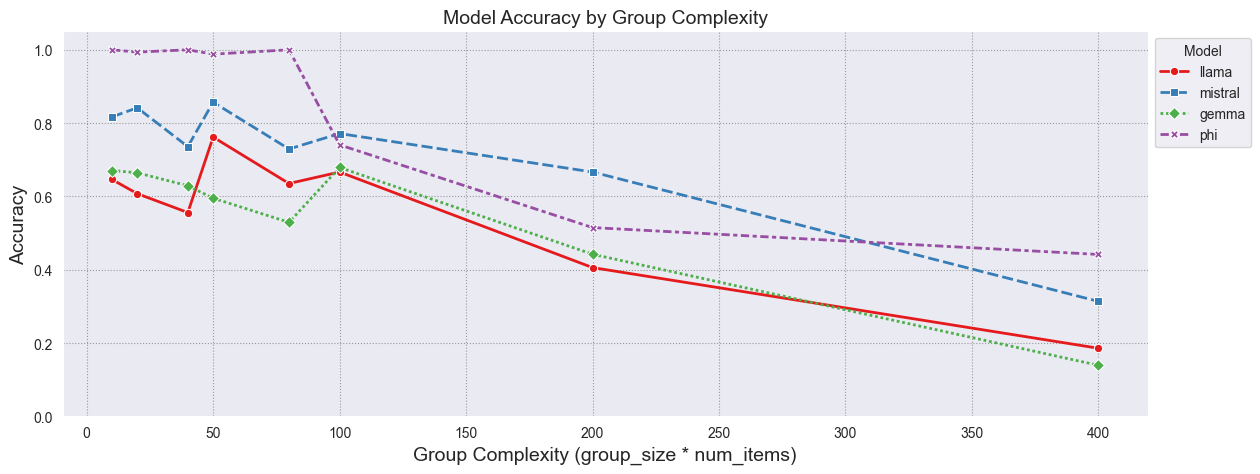

In [6]:

df["group_complexity"] = df["group_size"] * df["num_items"]

results = []

for model in ['llama', 'mistral', 'gemma', 'phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })

results_df = pd.DataFrame(results)

plt.figure(figsize=(14, 5))
sns.lineplot(
    data=results_df, x="group_complexity", y="precision", hue="model", 
    style="model", markers=["o", "s", "D", "X"],  linewidth=2, palette='Set1'
)

plt.title("Model Accuracy by Group Complexity", fontsize=14)
plt.xlabel("Group Complexity (group_size * num_items)", fontsize=14)
plt.ylabel("Accuracy",fontsize=14)
plt.ylim(0, 1.05)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.savefig('full-complexity.png', dpi=500, bbox_inches='tight')

plt.show()


In [10]:
## STRAT BREAKDOWN
results = []
for model in ['llama', 'mistral', 'gemma', 'phi']:
    
    for strategy, group in df.groupby("strategy"):
        correct_predictions = 0
        total_predictions = len(group)
        labels_pred = []
        labels_gold = []

        overlaps = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[model])

            overlap = gold_set & pred_set 

            if len(overlap) != 0:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

            if overlap:
                correct_predictions += 1
                overlaps.append(list(overlap)) 
            else:
                overlaps.append([])

        accuracy = correct_predictions / total_predictions
        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "strategy": strategy,
            "accuracy": accuracy,
            "precision": float(precision)
        })

results_df = pd.DataFrame(results)


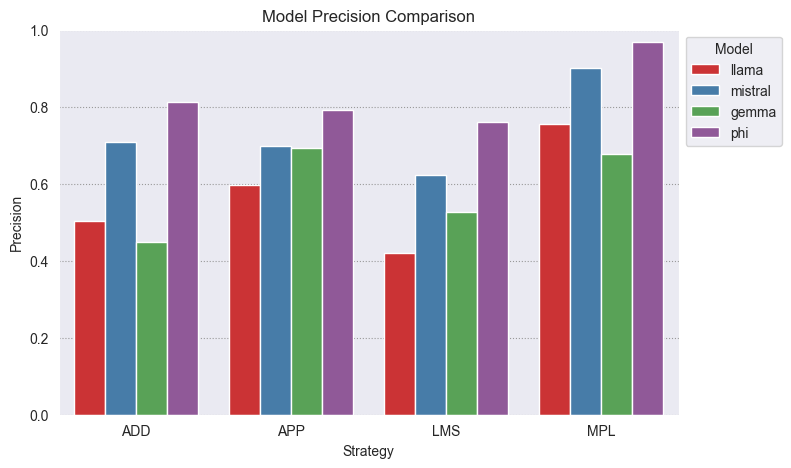

In [11]:
plt.figure(figsize=(8, 5))

ax = sns.barplot(x="strategy", y="precision", data=results_df, hue='model', palette="Set1")

ax.set_ylim(0, 1)

plt.title("Model Precision Comparison")
plt.xlabel("Strategy")
plt.ylabel("Precision")
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [16]:
results_df

,model,strategy,accuracy,precision
0,llama,ADD,0.503797,0.503797
1,llama,APP,0.595556,0.595556
2,llama,LMS,0.420213,0.420213
3,llama,MPL,0.755208,0.755208
4,mistral,ADD,0.708861,0.708861
5,mistral,APP,0.697778,0.697778
6,mistral,LMS,0.622340,0.622340
7,mistral,MPL,0.901042,0.901042
8,gemma,ADD,0.448101,0.448101
9,gemma,APP,0.693333,0.693333


In [ ]:
##### END OF FIRST RESULTS PART (REFERRED TO AS BASELINE IN UPCOMING SECTIONS) ######

In [36]:
### FUNCTIONS TO FIX INCONSISTENT LIST FORMATTING BY PHI (mainly when prompting for explanations)

def clean_phi_list(val):    
    if isinstance(val, list):
        cleaned_list = []
        for item in val:
            cleaned_list.extend(clean_phi_list(item))  
        return cleaned_list
    
    if isinstance(val, str):
        # Case: '["item_33"]'
        if val.startswith('["') and val.endswith('"]'):
            return [val[2:-2]]  #
        
        try:
            # Case:  ['item_33']
            evaluated = ast.literal_eval(val)
            if isinstance(evaluated, list):
                return clean_phi_list(evaluated) 
        except (SyntaxError, ValueError):
            pass  
    
        # Case: 'item_1, item_2' -> ['item_1', 'item_2']
        if ',' in val:
            return [item.strip() for item in val.split(',')]
    
    return [str(val)]

## because phi can be inconsistent in formatting
def ensure_strings_in_list(val):
    if isinstance(val, list):
        return [str(item) for item in val]  
    return [str(val)]  


def create_phi_overlap(df):
    phi_overlap_list = []

    for _, row in df.iterrows():
        gold_label = row['gold_label']
        phi = row['phi']

        gold_set = set(gold_label)
        phi_set = set(phi)
        overlap = gold_set.intersection(phi_set)

        if overlap:
            # phi_overlap = gold_label
            phi_overlap_list.append(gold_label)
        else:
            # random, it is incorrect anyways (only have to make sure it is not equal to gold_label)
            phi_overlap_list.append(["item_X"])  

    df['phi_overlap'] = phi_overlap_list
    return df


In [ ]:
### EXPLANATIONS

In [37]:
result_file = f'results/all_results-explanations.csv'
df = pd.read_csv(result_file, sep=',')
print(len(df))
df

223


,groupId,group_size,num_items,strategy,gold_label,phi
0,751,4,50,ADD,['item_20'],['item_9']
1,752,2,50,LMS,['item_33'],"['[""item_33""]']"
2,753,4,50,ADD,['item_21'],"['item_13', 'item_22']"
3,754,8,50,APP,"['item_1', 'item_35']","['item_1', 'item_3', 'item_6', 'item_7', 'item..."
4,755,4,50,ADD,['item_18'],"['item_15', 'item_25', 'item_35']"
...,...,...,...,...,...,...
218,995,2,50,APP,"['item_1', 'item_14', 'item_15', 'item_29', 'i...","['item_1, item_14, item_44, item_49']"
219,997,8,50,LMS,['item_49'],['item_46']
220,998,2,50,ADD,['item_28'],['item_4']
221,999,4,50,ADD,['item_31'],['item_23']


In [38]:

df['gold_label'] = df['gold_label'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))
df['phi'] = df['phi'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])
df['phi'] = df['phi'].apply(lambda x: [str(item) for item in x])

df = create_phi_overlap(df)

y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
y_pred = df['phi_overlap'].apply(lambda x: x[0]).tolist()

precision = precision_score(y_true, y_pred, average='micro')



print(f"Precision Score: {precision}")
df


Precision Score: 0.5919282511210763


,groupId,group_size,num_items,strategy,gold_label,phi,phi_overlap
0,751,4,50,ADD,[item_20],[item_9],[item_X]
1,752,2,50,LMS,[item_33],[item_33],[item_33]
2,753,4,50,ADD,[item_21],"[item_13, item_22]",[item_X]
3,754,8,50,APP,"[item_1, item_35]","[item_1, item_3, item_6, item_7, item_8, item_...","[item_1, item_35]"
4,755,4,50,ADD,[item_18],"[item_15, item_25, item_35]",[item_X]
...,...,...,...,...,...,...,...
218,995,2,50,APP,"[item_1, item_14, item_15, item_29, item_40, i...","[item_1, item_14, item_44, item_49]","[item_1, item_14, item_15, item_29, item_40, i..."
219,997,8,50,LMS,[item_49],[item_46],[item_X]
220,998,2,50,ADD,[item_28],[item_4],[item_X]
221,999,4,50,ADD,[item_31],[item_23],[item_X]


/var/folders/d4/ddh81b1j0r94c7qm3t38mqcc0000gn/T/ipykernel_57739/527050534.py:35: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  sns.lineplot(


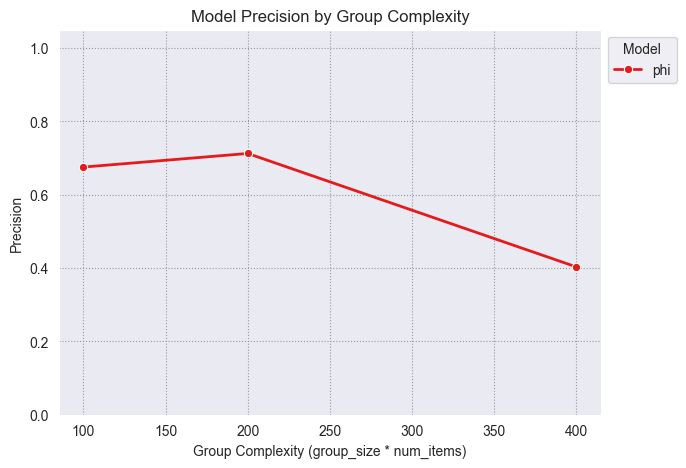

In [121]:

df["group_complexity"] = df["group_size"] * df["num_items"]

results = []

for model in ['phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })

results_df = pd.DataFrame(results)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=results_df, x="group_complexity", y="precision", hue="model", 
    style="model", markers=["o", "s", "D", "X"], dashes=False, linewidth=2, palette='Set1'
)

plt.title("Model Precision by Group Complexity")
plt.xlabel("Group Complexity (group_size * num_items)")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [122]:
results_df

,model,group_complexity,precision
0,phi,100,0.675000
1,phi,200,0.712121
2,phi,400,0.402597


In [ ]:
### FEW SHOT LEARNING

In [40]:
result_file = f'results/all_results-fs.csv'
df = pd.read_csv(result_file, sep=',')
print(len(df))

209


In [41]:
import pandas as pd
import ast
from sklearn.metrics import precision_score



df['gold_label'] = df['gold_label'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))
df['phi'] = df['phi'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])
df['phi'] = df['phi'].apply(lambda x: [str(item) for item in x])

df = create_phi_overlap(df)

y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
y_pred = df['phi_overlap'].apply(lambda x: x[0]).tolist()

precision = precision_score(y_true, y_pred, average='micro')


print(f"Precision Score: {precision}")
df


Precision Score: 0.84688995215311


,groupId,group_size,num_items,strategy,gold_label,phi,phi_overlap
0,751,4,50,LMS,[item_21],"[item_20, item_21, item_19, item_23, item_25]",[item_21]
1,752,2,50,ADD,[item_33],[item_33],[item_33]
2,753,4,50,APP,[item_17],"[item_21, item_34, item_40, item_44, item_50]",[item_X]
3,754,8,50,ADD,[item_1],"[item_24, item_25, item_27, item_28, item_45]",[item_X]
4,755,4,50,ADD,[item_18],"[item_18, item_23, item_21, item_45, item_27]",[item_18]
...,...,...,...,...,...,...,...
204,996,4,50,LMS,"[item_12, item_49]","[item_49, item_10, item_20, item_12, item_28]","[item_12, item_49]"
205,997,8,50,ADD,[item_46],"[item_46, item_30, item_38, item_48, item_36]",[item_46]
206,998,2,50,ADD,[item_28],[item_28],[item_28]
207,999,4,50,APP,[item_31],"[item_35, item_31, item_10, item_48, item_49]",[item_31]


/var/folders/d4/ddh81b1j0r94c7qm3t38mqcc0000gn/T/ipykernel_45595/518387072.py:37: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  sns.lineplot(


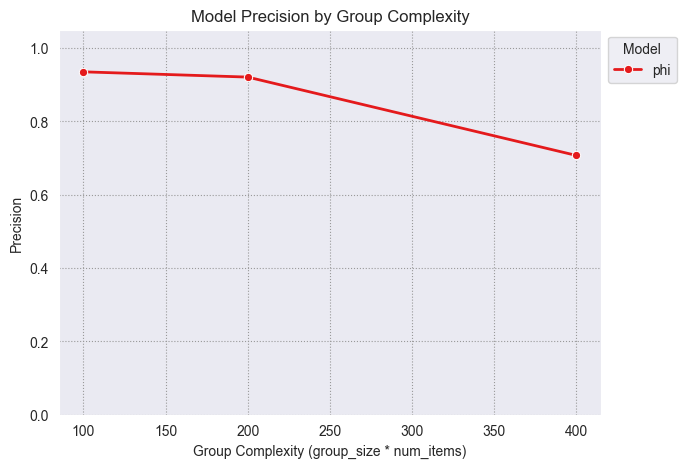

In [169]:

df["group_complexity"] = df["group_size"] * df["num_items"]


results = []

for model in ['phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  # Use the overlap column

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })


results_df = pd.DataFrame(results)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=results_df, x="group_complexity", y="precision", hue="model", 
    style="model", markers=["o", "s", "D", "X"], dashes=False, linewidth=2, palette='Set1'
)

plt.title("Model Precision by Group Complexity")
plt.xlabel("Group Complexity (group_size * num_items)")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [170]:
results_df

,model,group_complexity,precision
0,phi,100,0.934783
1,phi,200,0.920455
2,phi,400,0.706667


In [ ]:
### DOUBLE CHECK BASELINE

In [132]:

result_file = f'results/all_results-baseline.csv'
df = pd.read_csv(result_file, sep=',')
len(df)
#df


209

In [133]:
import pandas as pd
import ast
from sklearn.metrics import precision_score



df['gold_label'] = df['gold_label'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))
df['phi'] = df['phi'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])
df['phi'] = df['phi'].apply(lambda x: [str(item) for item in x])

df = create_phi_overlap(df)

y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
y_pred = df['phi_overlap'].apply(lambda x: x[0]).tolist()

precision = precision_score(y_true, y_pred, average='micro')


print(f"Precision Score: {precision}")
df


Precision Score: 0.569377990430622


,groupId,group_size,num_items,strategy,gold_label,phi,phi_overlap
0,751,4,50,LMS,[item_21],[item_10],[item_X]
1,752,2,50,ADD,[item_33],[item_33],[item_33]
2,754,8,50,ADD,[item_1],"[item_35, item_46]",[item_X]
3,755,4,50,LMS,"[item_18, item_33]","[item_1, item_8, item_14]",[item_X]
4,756,2,50,ADD,"[item_13, item_22, item_29]","[Item_13, Item_22, Item_29]",[item_X]
...,...,...,...,...,...,...,...
204,995,2,50,LMS,"[item_1, item_44]",[item_1],"[item_1, item_44]"
205,997,8,50,ADD,[item_46],[item_46],[item_46]
206,998,2,50,LMS,"[item_26, item_28]",[item_26],"[item_26, item_28]"
207,999,4,50,LMS,[item_31],"[item_3, item_15, item_47]",[item_X]


/var/folders/d4/ddh81b1j0r94c7qm3t38mqcc0000gn/T/ipykernel_57739/518387072.py:37: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  sns.lineplot(


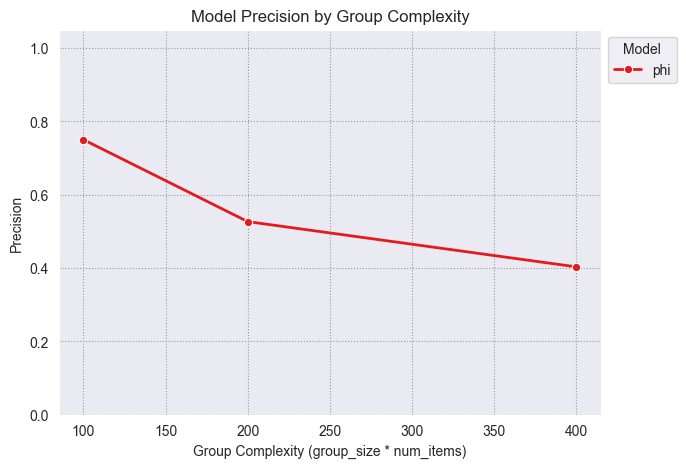

In [134]:

df["group_complexity"] = df["group_size"] * df["num_items"]


results = []

for model in ['phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  # Use the overlap column

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })


results_df = pd.DataFrame(results)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=results_df, x="group_complexity", y="precision", hue="model", 
    style="model", markers=["o", "s", "D", "X"], dashes=False, linewidth=2, palette='Set1'
)

plt.title("Model Precision by Group Complexity")
plt.xlabel("Group Complexity (group_size * num_items)")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [135]:
results_df

,model,group_complexity,precision
0,phi,100,0.750000
1,phi,200,0.526316
2,phi,400,0.402778


In [ ]:
#### CONTEXT ####

In [93]:

result_file = f'results/all_results-context.csv'
df = pd.read_csv(result_file, sep=',')
len(df)
#df


230

In [94]:
import pandas as pd
import ast
from sklearn.metrics import precision_score



df['gold_label'] = df['gold_label'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))
df['phi'] = df['phi'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])
df['phi'] = df['phi'].apply(lambda x: [str(item) for item in x])

df = create_phi_overlap(df)

y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
y_pred = df['phi_overlap'].apply(lambda x: x[0]).tolist()

precision = precision_score(y_true, y_pred, average='micro')


print(f"Precision Score: {precision}")
df


Precision Score: 0.5347826086956522


,groupId,group_size,num_items,strategy,gold_label,phi,phi_overlap
0,751,4,50,ADD,[Three Little Bops (1957)],[Resan Till Melonia (1989)],[item_X]
1,752,2,50,LMS,[Coraline (2009)],[Resan Till Melonia (1989)],[item_X]
2,753,4,50,ADD,[Death Metal Angola (2014)],"[Headfirst (2014), 4th Period Mystery (2009)]",[item_X]
3,754,8,50,LMS,"[Deprogrammed (2015), Urban Warriors (1987)]",[The Moonstone (1997)],[item_X]
4,755,4,50,LMS,"[Café Derby (2015), Resan Till Melonia (1989)]","[Carcinoma (2014), Museum (2016)]",[item_X]
...,...,...,...,...,...,...,...
225,996,4,50,APP,"[Just Before Losing Everything (2013), That Bu...",[Just Before Losing Everything (2013)],"[Just Before Losing Everything (2013), That Bu..."
226,997,8,50,ADD,[Khottabych (2006)],[Khottabych (2006)],[Khottabych (2006)]
227,998,2,50,LMS,"[Jolly Fellows (2009), The Decline (2020)]","[Wild Geese, The (1978), Nô (1998)]",[item_X]
228,999,4,50,APP,[Nô (1998)],"[Freedomfighters (Libertarias) (1996), Death M...",[item_X]


/var/folders/d4/ddh81b1j0r94c7qm3t38mqcc0000gn/T/ipykernel_57739/518387072.py:37: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  sns.lineplot(


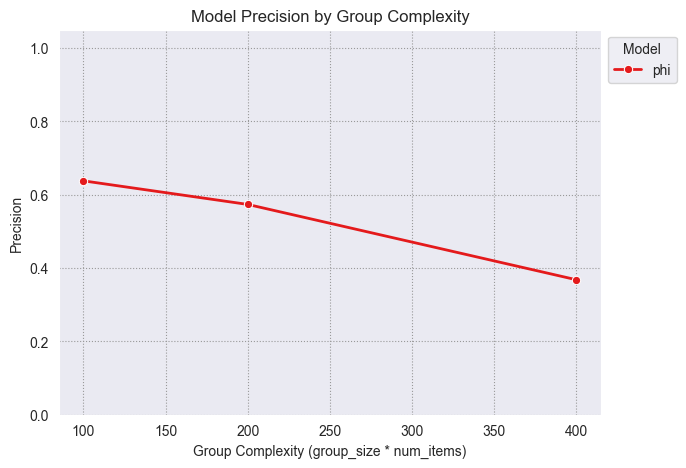

In [95]:

df["group_complexity"] = df["group_size"] * df["num_items"]


results = []

for model in ['phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  # Use the overlap column

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })


results_df = pd.DataFrame(results)

plt.figure(figsize=(7, 5))
sns.lineplot(
    data=results_df, x="group_complexity", y="precision", hue="model", 
    style="model", markers=["o", "s", "D", "X"], dashes=False, linewidth=2, palette='Set1'
)

plt.title("Model Precision by Group Complexity")
plt.xlabel("Group Complexity (group_size * num_items)")
plt.ylabel("Precision")
plt.ylim(0, 1.05)
plt.legend(title="Model", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [96]:
results_df

,model,group_complexity,precision
0,phi,100,0.637500
1,phi,200,0.573171
2,phi,400,0.367647


In [88]:
import langchain
print(langchain.__version__)

0.3.2


In [91]:
####### DATA FORMATTING CONDITIONS

result_file = f'results/all_results-asdict.csv'
df = pd.read_csv(result_file, sep=',')
print(len(df))

df['gold_label'] = df['gold_label'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))
df['phi'] = df['phi'].apply(lambda x: clean_phi_list(ast.literal_eval(x)))

df['gold_label'] = df['gold_label'].apply(lambda x: [str(item) for item in x])
df['phi'] = df['phi'].apply(lambda x: [str(item) for item in x])

df = create_phi_overlap(df)

y_true = df['gold_label'].apply(lambda x: x[0]).tolist()
y_pred = df['phi_overlap'].apply(lambda x: x[0]).tolist()

precision = precision_score(y_true, y_pred, average='micro')


print(f"Precision Score: {precision}")

df["group_complexity"] = df["group_size"] * df["num_items"]


results = []

for model in ['phi']:
    
    for complexity, group in df.groupby("group_complexity"):
        labels_pred = []
        labels_gold = []

        for _, row in group.iterrows():
            gold_set = set(row['gold_label'])
            pred_set = set(row[f"{model}_overlap"])  # Use the overlap column

            overlap = gold_set & pred_set 

            if overlap:
                labels_pred.append(list(overlap)[0])
                labels_gold.append(list(overlap)[0])
            else:
                labels_pred.append(list(pred_set)[0])
                labels_gold.append(list(gold_set)[0])

        precision = precision_score(labels_gold, labels_pred, average='micro')

        results.append({
            "model": model,
            "group_complexity": complexity,
            "precision": float(precision)
        })


results_df = pd.DataFrame(results)
print(results_df)





8
Precision Score: 0.125
  model  group_complexity  precision
0   phi               100   0.333333
1   phi               200   0.000000
2   phi               400   0.000000


In [ ]:
#### SAMENVATTING ##### 

# GRAPH WITH ALL CONDITIONS

mean baseline: 0.5563333333333333
mean explanations: 0.5963333333333334
mean few-shot: 0.854
mean context: 0.5256666666666666


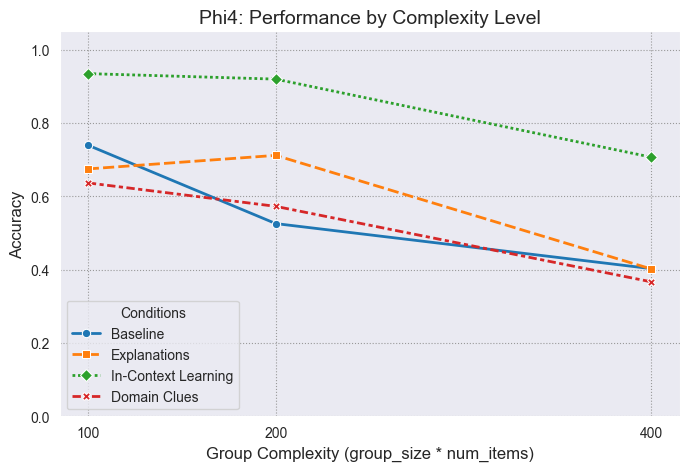

In [7]:
import statistics as s
explanations = [0.675, 0.712, 0.402]
baseline = [0.74, 0.526, 0.403]
fs = [0.935,0.920,0.707]
context = [0.637,0.573,0.367]
comp = [100,200,400]
print('mean baseline:', s.mean(baseline))
print('mean explanations:', s.mean(explanations))
print('mean few-shot:', s.mean(fs))
print('mean context:', s.mean(context))

#
df2 = pd.DataFrame(comp)
df2.columns =['Complexity']
df2['Baseline'] = baseline
df2['Explanations'] = explanations
df2['In-Context Learning'] = fs
df2['Domain Clues'] = context


# Melt the dataframe to long format for plotting
df2_melted = df2.melt(id_vars=["Complexity"], var_name="Method", value_name="Score")

# Plot the lineplot
plt.figure(figsize=(8, 5))
sns.lineplot(data=df2_melted, x="Complexity", y="Score", hue="Method", style="Method", markers=["o", "s", "D", "X"], linewidth=2)

# Formatting the plot
plt.title("Phi4: Performance by Complexity Level", fontsize=14)
plt.xlabel("Group Complexity (group_size * num_items)", fontsize=12)
plt.ylabel("Accuracy",fontsize=12)
plt.ylim(0, 1.05)  # Assuming scores range from 0 to 1
plt.xticks([100, 200, 400])  # Set specific x-axis ticks
plt.legend(title="Conditions")
plt.grid(True)
plt.savefig('conditions-performance.png', dpi=500, bbox_inches='tight')

plt.show()

In [116]:
import pandas as pd
import numpy as np
from ast import literal_eval

df2 = pd.read_csv('results/all_results-ranking.csv')  

def dcg(relevance_scores, k):
    rel = np.array(relevance_scores, dtype=float)
    rel = rel[:k] if len(rel) >= k else np.pad(rel, (0, k - len(rel)), 'constant')
    discounts = np.log2(np.arange(2, k + 1))
    return rel[0] + np.sum(rel[1:] / discounts) if k > 0 else 0.0

def ndcg(relevance_scores, k):
    actual_dcg = dcg(relevance_scores, k)
    ideal_dcg = dcg(sorted(relevance_scores, reverse=True), k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

def get_relevance_scores(list1, list2):
    """
    binary relevance. 1 if correct, 0 if not
    """
    return [1 if item in list2 else 0 for item in list1]

ndcg10_sums = {'mistral': 0, 'phi': 0}
count = {'mistral': 0, 'phi': 0}

for _, row in df2.iterrows():
    if type(row['gold_label']) == list:
        gold_label = row['gold_label']
    else:
        gold_label = literal_eval(row['gold_label'])
    try:
        mistral_preds = literal_eval(row['mistral'])
        phi_preds = literal_eval(row['phi'])
    except (ValueError, SyntaxError):
        #print('h')
        continue 

    # Check list lengths
    if len(mistral_preds) < 10 or len(phi_preds) < 10:
        #print('h')
        continue  
    mistral_preds = mistral_preds[:10]  
    phi_preds = phi_preds[:10]

    rel_mistral = get_relevance_scores(mistral_preds, gold_label)
    rel_phi = get_relevance_scores(phi_preds, gold_label)

    ndcg10_sums['mistral'] += ndcg(rel_mistral, 10)
    ndcg10_sums['phi'] += ndcg(rel_phi, 10)
    count['mistral'] += 1
    count['phi'] += 1

avg_ndcg10 = {model: ndcg10_sums[model] / count[model] for model in ndcg10_sums if count[model] > 0}


print("Average NDCG@10:")
for model, score in avg_ndcg10.items():
    print(f"{model}: {score:.4f}")


['item_16', 'item_34', 'item_14', 'item_28', 'item_21', 'item_41', 'item_10', 'item_25', 'item_32', 'item_40'] ['item_21', 'item_20', 'item_25', 'item_14', 'item_44', 'item_17', 'item_24', 'item_23', 'item_1', 'item_13']
['item_3', 'item_33', 'item_30', 'item_29', 'item_13', 'item_6', 'item_39', 'item_36', 'item_40', 'item_12'] ['item_33', 'item_48', 'item_29', 'item_13', 'item_14', 'item_40', 'item_30', 'item_12', 'item_28', 'item_2']
['item_10', 'item_5', 'item_7', 'item_3', 'item_2', 'item_8', 'item_4', 'item_50', 'item_44', 'item_45'] ['item_21', 'item_17', 'item_35', 'item_31', 'item_11', 'item_45', 'item_44', 'item_24', 'item_12', 'item_30']
['item_35', 'item_46', 'item_47', 'item_48', 'item_34', 'item_36', 'item_39', 'item_40', 'item_42', 'item_49'] ['item_1', 'item_35', 'item_25', 'item_2', 'item_16', 'item_7', 'item_46', 'item_23', 'item_27', 'item_29']
['item_13', 'item_22', 'item_29', 'item_21', 'item_1', 'item_9', 'item_19', 'item_24', 'item_33', 'item_34'] ['item_13', 'ite

In [291]:
import pandas as pd
import numpy as np
from ast import literal_eval

df2 = pd.read_csv('results/all_results-ranking.csv')  
df2=df2[df2.groupId!=1002]

def dcg(relevance_scores, k):
    relevance_scores = np.array(relevance_scores, dtype=float)
    if len(relevance_scores) > k:
        relevance_scores = relevance_scores[:k] 


    discounts = np.log2(np.arange(1, len(relevance_scores) + 1) + 1)
    return np.sum(relevance_scores / discounts)

def ndcg(relevance_scores, k):
    actual_dcg = dcg(relevance_scores, k)  
    ideal_dcg = dcg(sorted(relevance_scores, reverse=True), k)  
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0  

def get_relevance_scores(pred_list, gold_item):
    return [1 if item in gold_item else 0 for item in pred_list]

df2['ndcg_mistral'] = np.nan
df2['ndcg_phi'] = np.nan
df2['group_complexity'] = df2['group_size'] * df2['num_items']

ndcg10_sums = {'mistral': 0, 'phi': 0}
count = {'mistral': 0, 'phi': 0}

ndcg5_sums = {'mistral': 0, 'phi': 0}

for _, row in df2.iterrows():
    try:
        gold_label = literal_eval(row['gold_label'])
        mistral_preds = literal_eval(row['mistral'])[:10]
        phi_preds = literal_eval(row['phi'])[:10]
    except (ValueError, SyntaxError):
        continue  

    if len(mistral_preds) < 10 or len(phi_preds) < 10:
        continue  

    rel_mistral = [1 if item in gold_label else 0 for item in mistral_preds]
    rel_phi = [1 if item in gold_label else 0 for item in phi_preds]

    df2.at[_, 'ndcg10_mistral'] = ndcg(rel_mistral, 10)
    df2.at[_, 'ndcg10_phi'] = ndcg(rel_phi, 10)

    ndcg10_sums['mistral'] += df2.at[_, 'ndcg10_mistral']
    ndcg10_sums['phi'] += df2.at[_, 'ndcg10_phi']
    count['mistral'] += 1
    count['phi'] += 1

avg_ndcg10 = {model: ndcg10_sums[model] / count[model] for model in ndcg10_sums if count[model] > 0}
count = {'mistral': 0, 'phi': 0}

for _, row in df2.iterrows():
    try:
        gold_label = literal_eval(row['gold_label'])[:5]
        mistral_preds = literal_eval(row['mistral'])[:5]
        phi_preds = literal_eval(row['phi'])[:5]
    except (ValueError, SyntaxError):
        continue  

    if len(mistral_preds) < 5 or len(phi_preds) < 5:
        continue  

    rel_mistral = [1 if item in gold_label else 0 for item in mistral_preds]
    rel_phi = [1 if item in gold_label else 0 for item in phi_preds]

    df2.at[_, 'ndcg5_mistral'] = ndcg(rel_mistral, 5)
    df2.at[_, 'ndcg5_phi'] = ndcg(rel_phi, 5)

    ndcg5_sums['mistral'] += df2.at[_, 'ndcg5_mistral']
    ndcg5_sums['phi'] += df2.at[_, 'ndcg5_phi']
    count['mistral'] += 1
    count['phi'] += 1

avg_ndcg5 = {model: ndcg5_sums[model] / count[model] for model in ndcg5_sums if count[model] > 0}


avg_ndcg_by_complexity = df2.groupby('group_complexity')[['ndcg10_mistral', 'ndcg10_phi']].mean()

print("Average NDCG@10:")
for model, score in avg_ndcg10.items():
    print(f"{model}: {score:.4f}")

print(avg_ndcg_by_complexity)

avg_ndcg_by_strat = df2.groupby('strategy')[['ndcg10_mistral', 'ndcg10_phi']].mean()

print(avg_ndcg_by_strat)


print('\n--------- @5 ------------')
print("\nAverage NDCG@5:")
for model, score in avg_ndcg5.items():
    print(f"{model}: {score:.4f}")

avg_ndcg5_by_complexity = df2.groupby('group_complexity')[['ndcg5_mistral', 'ndcg5_phi']].mean()
print(avg_ndcg5_by_complexity)


Average NDCG@10:
mistral: 0.7349
phi: 0.8738
                  ndcg10_mistral  ndcg10_phi
group_complexity                            
100                     0.779785    0.969926
200                     0.717082    0.833804
400                     0.670964    0.739165
          ndcg10_mistral  ndcg10_phi
strategy                            
ADD             0.781057    0.927802
APP             0.661970    0.906190
LMS             0.666479    0.813069
MPL             0.762264    0.800144

--------- @5 ------------

Average NDCG@5:
mistral: 0.5639
phi: 0.7892
                  ndcg5_mistral  ndcg5_phi
group_complexity                          
100                    0.651285   0.926669
200                    0.544956   0.756167
400                    0.418670   0.564756
